# Temporary Impact Modeling
This notebook models the temporary market impact function $g_t(x)$ using real LOB data from 3 stocks.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")

## Load Data

In [ ]:
impact_df = pd.read_csv("data/temporary_impact.csv")
impact_df.head()

,symbol,timestamp,side,x,g,mid,liquidity_top3
0,SOUN,2025-04-03 13:30:00.005642878+00:00,buy,164,0.000000,7.9,610
1,SOUN,2025-04-03 13:30:00.005642878+00:00,buy,168,0.000238,7.9,610
2,SOUN,2025-04-03 13:30:00.005642878+00:00,buy,198,0.004545,7.9,610
3,SOUN,2025-04-03 13:30:00.005642878+00:00,buy,277,0.011408,7.9,610
4,SOUN,2025-04-03 13:30:00.005642878+00:00,buy,306,0.007582,7.9,610


## Split Data

In [37]:
buy_df = impact_df[impact_df['side'] == 'buy']
sell_df = impact_df[impact_df['side'] == 'sell']
X_buy = buy_df[['x']].values
y_buy = buy_df['g'].values
X_sell = sell_df[['x']].values
y_sell = sell_df['g'].values

## Fit Models

In [38]:
lin_model_buy = LinearRegression().fit(X_buy, y_buy)
lin_model_sell = LinearRegression().fit(X_sell, y_sell)
poly_model_buy = make_pipeline(PolynomialFeatures(degree=2), LinearRegression()).fit(X_buy, y_buy)
poly_model_sell = make_pipeline(PolynomialFeatures(degree=2), LinearRegression()).fit(X_sell, y_sell)
nn_model_buy = MLPRegressor(hidden_layer_sizes=(32, 32), activation='relu', max_iter=1000).fit(X_buy, y_buy)
nn_model_sell = MLPRegressor(hidden_layer_sizes=(32, 32), activation='relu', max_iter=1000).fit(X_sell, y_sell)

## Predict and Compare

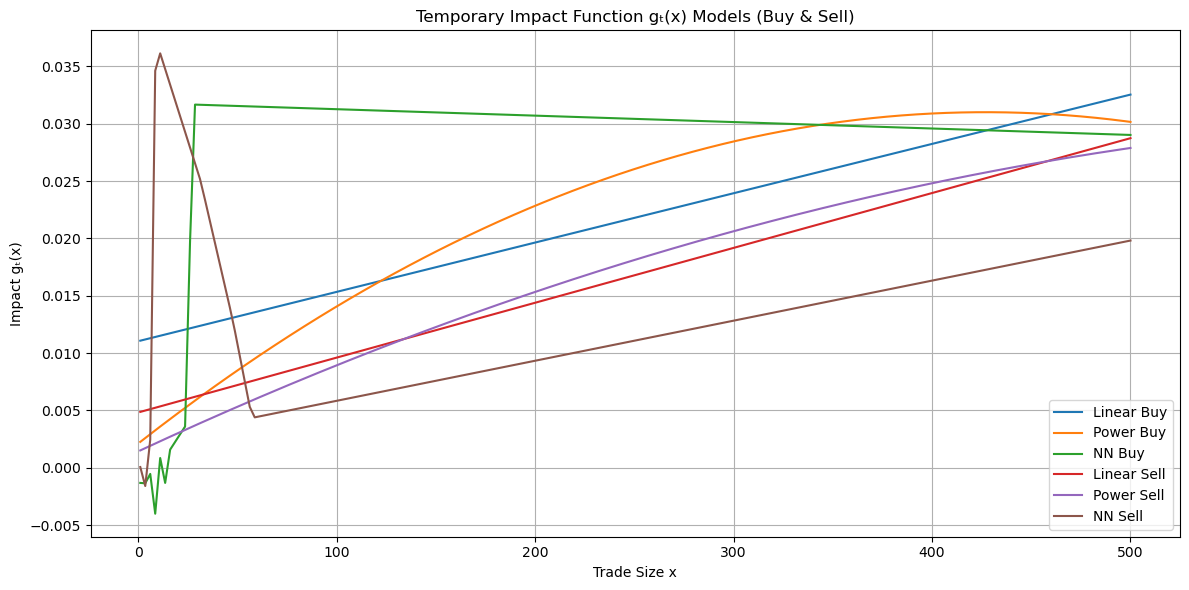

In [39]:
x_test = np.linspace(1, 500, 200).reshape(-1, 1)
preds = {
    "x": x_test.flatten(),
    "Linear Buy": lin_model_buy.predict(x_test),
    "Power Buy": poly_model_buy.predict(x_test),
    "NN Buy": nn_model_buy.predict(x_test),
    "Linear Sell": lin_model_sell.predict(x_test),
    "Power Sell": poly_model_sell.predict(x_test),
    "NN Sell": nn_model_sell.predict(x_test),
}
pred_df = pd.DataFrame(preds)
plt.figure(figsize=(12, 6))
sns.lineplot(data=pred_df, x="x", y="Linear Buy", label="Linear Buy")
sns.lineplot(data=pred_df, x="x", y="Power Buy", label="Power Buy")
sns.lineplot(data=pred_df, x="x", y="NN Buy", label="NN Buy")
sns.lineplot(data=pred_df, x="x", y="Linear Sell", label="Linear Sell")
sns.lineplot(data=pred_df, x="x", y="Power Sell", label="Power Sell")
sns.lineplot(data=pred_df, x="x", y="NN Sell", label="NN Sell")
plt.title("Temporary Impact Function gₜ(x) Models (Buy & Sell)")
plt.xlabel("Trade Size x")
plt.ylabel("Impact gₜ(x)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

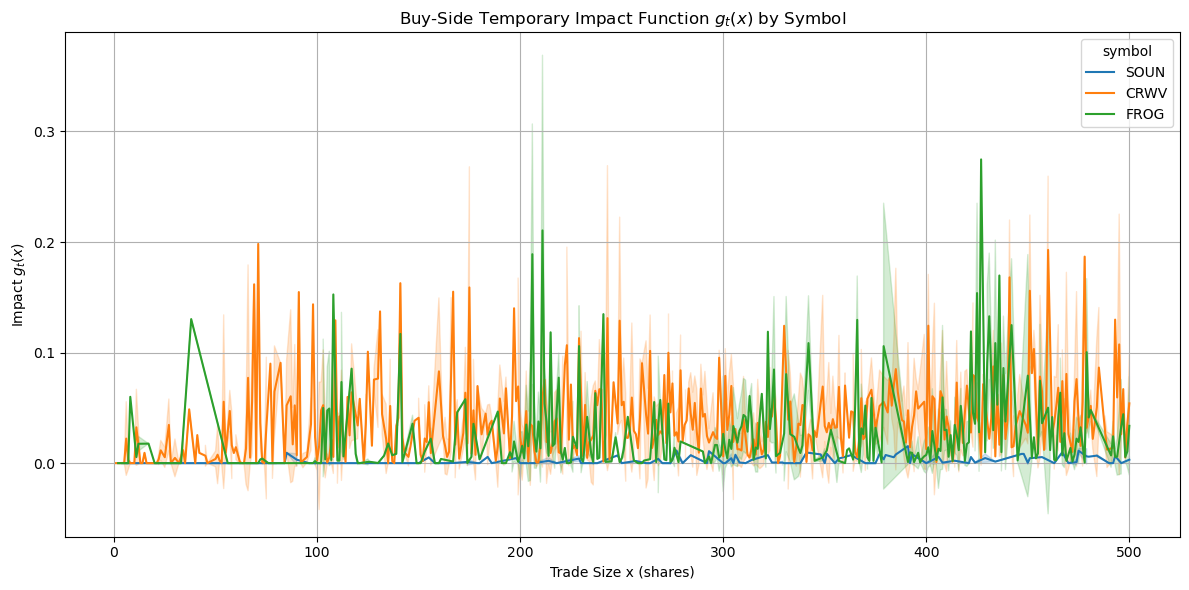

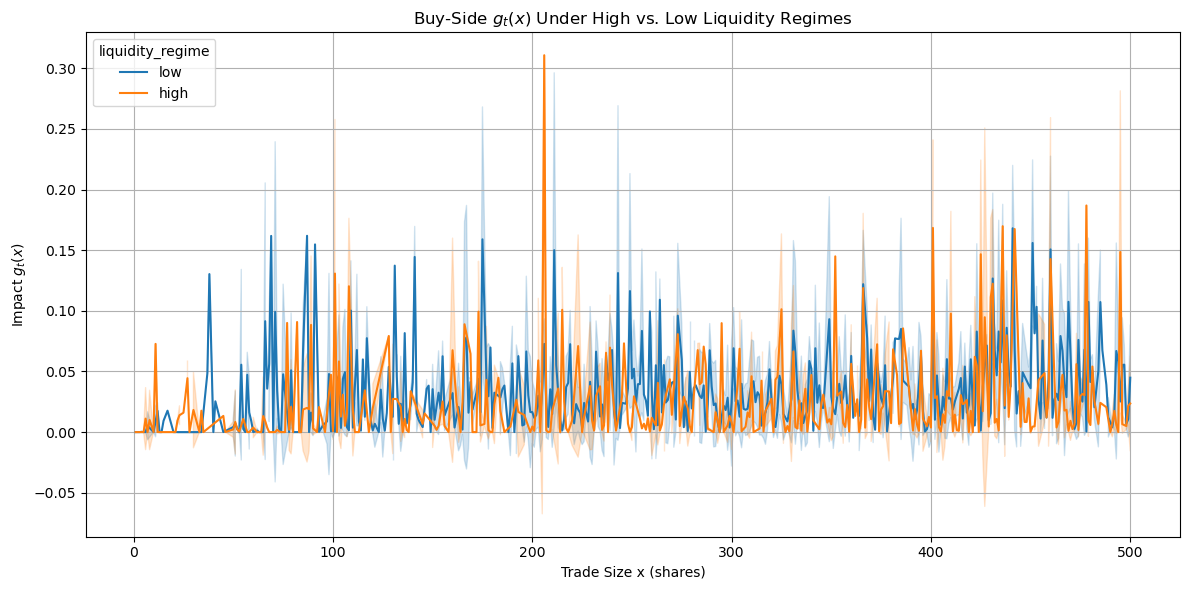

In [40]:
# Ensure correct data types
impact_df['symbol'] = impact_df['symbol'].astype(str)
impact_df['side'] = impact_df['side'].astype(str)

# 1. Plot per-symbol g(x) for BUY side
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=impact_df[impact_df['side'] == 'buy'],
    x='x', y='g', hue='symbol', errorbar='sd', estimator='mean'
)
plt.title("Buy-Side Temporary Impact Function $g_t(x)$ by Symbol")
plt.xlabel("Trade Size x (shares)")
plt.ylabel("Impact $g_t(x)$")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Liquidity regime analysis: split by top-3 liquidity (high vs. low)
impact_df['liquidity_regime'] = pd.qcut(
    impact_df['liquidity_top3'], q=2, labels=["low", "high"])

# 3. Plot g(x) under different liquidity regimes
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=impact_df[impact_df['side'] == 'buy'],
    x='x', y='g', hue='liquidity_regime', errorbar='sd', estimator='mean'
)
plt.title("Buy-Side $g_t(x)$ Under High vs. Low Liquidity Regimes")
plt.xlabel("Trade Size x (shares)")
plt.ylabel("Impact $g_t(x)$")
plt.grid(True)
plt.tight_layout()
plt.show()

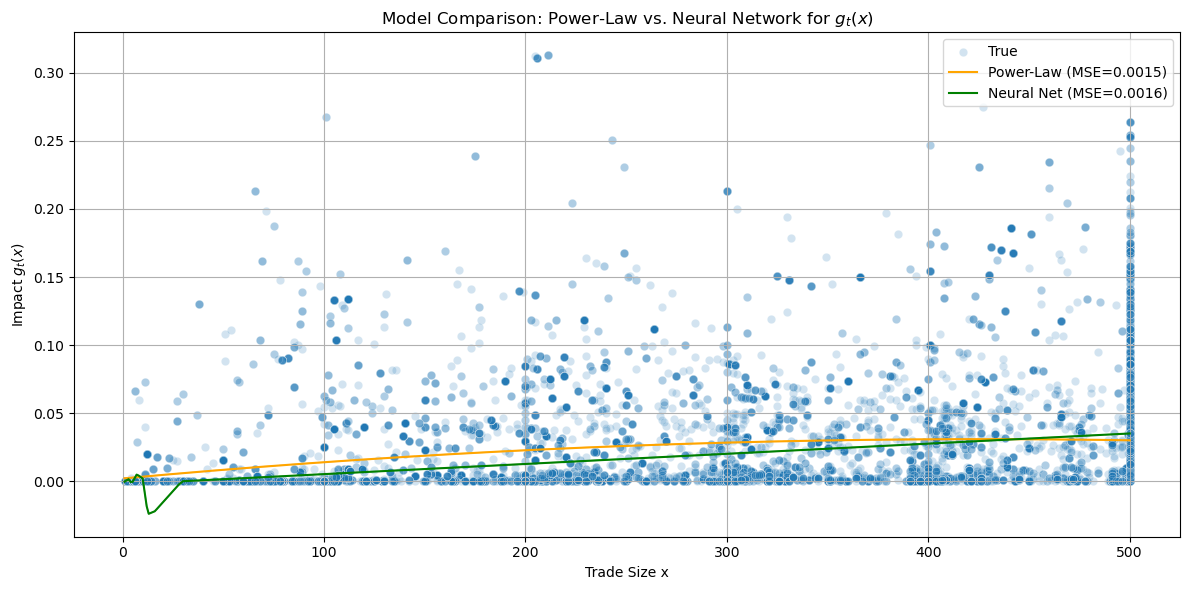

In [41]:
# Select BUY side only for modeling
df_buy = impact_df[(impact_df['side'] == 'buy') & (
    impact_df['x'] <= 500)]

# Prepare X, y
X = df_buy[['x']]
y = df_buy['g']

# 1. Power Law / Polynomial (quadratic)
poly_model = make_pipeline(PolynomialFeatures(2), LinearRegression())
poly_model.fit(X, y)
y_poly = poly_model.predict(X)
mse_poly = mean_squared_error(y, y_poly)

# 2. Neural Network (MLP)
mlp = MLPRegressor(hidden_layer_sizes=(32, 32),
                   activation='relu', max_iter=500, random_state=42)
mlp.fit(X, y)
y_mlp = mlp.predict(X)
mse_mlp = mean_squared_error(y, y_mlp)

# Plot comparison
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df_buy['x'], y=df_buy['g'], label="True", alpha=0.2)
sns.lineplot(x=df_buy['x'], y=y_poly, color='orange',
             label=f"Power-Law (MSE={mse_poly:.4f})")
sns.lineplot(x=df_buy['x'], y=y_mlp, color='green',
             label=f"Neural Net (MSE={mse_mlp:.4f})")
plt.title("Model Comparison: Power-Law vs. Neural Network for $g_t(x)$")
plt.xlabel("Trade Size x")
plt.ylabel("Impact $g_t(x)$")
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
def impact_cost_powerlaw(x, alpha, beta):
    return np.sum(alpha * x ** (beta + 1))  # +1 for total $ impact

In [43]:
def impact_cost_poly(x, poly_model):
    # Predict g(x) for each x and sum up total cost
    x = np.array(x).reshape(-1, 1)
    g = poly_model.predict(x)
    return np.sum(g * x.flatten())

In [44]:
def impact_cost_nn(x, nn_model):
    x = np.array(x).reshape(-1, 1)
    g = nn_model.predict(x)
    return np.sum(g * x.flatten())

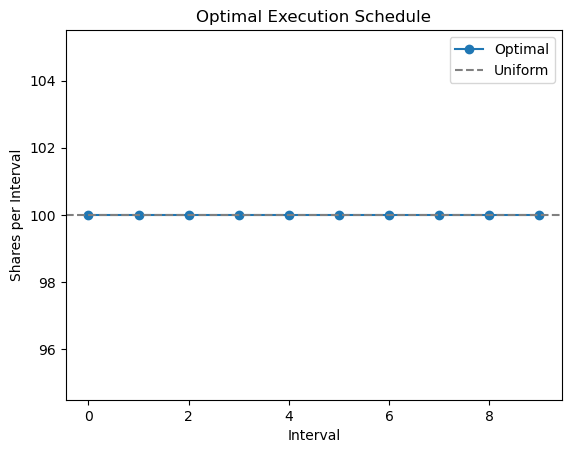

Total modeled cost (optimal): 100000.000
Total modeled cost (uniform): 100000.000


In [45]:
from scipy.optimize import minimize

# Suppose your fitted model is g(x) = alpha * x^beta
alpha = 0.001  # example, use your fit
beta = 2.5   # example, use your fit
S = 1000       # total shares
N = 10         # 10 intervals


def impact_cost(x):
    return np.sum(alpha * x ** (beta + 1))  # (beta+1) for total dollar impact


x0 = np.full(N, S/N)
cons = {'type': 'eq', 'fun': lambda x: np.sum(x) - S}
bounds = [(0, S)] * N

res = minimize(impact_cost, x0, bounds=bounds,
               constraints=[cons], method='SLSQP')
x_opt = res.x

plt.plot(x_opt, marker='o', label='Optimal')
plt.axhline(S/N, color='gray', linestyle='--', label='Uniform')
plt.xlabel('Interval')
plt.ylabel('Shares per Interval')
plt.title('Optimal Execution Schedule')
plt.legend()
plt.show()

print(f"Total modeled cost (optimal): {impact_cost(x_opt):.3f}")
print(f"Total modeled cost (uniform): {impact_cost(np.full(N, S/N)):.3f}")